#Projeto fim a fim utilizando Regressão Linear
---

# 1.0 Introdução

O dataset utilizado possui notas dos alunos de vários cursos da UFRN do ano de 2015 a 2017. A ideia é achar a relação entre as notas da primeira unidade e da segunda unidade da matéria de Cálculo I.

Para padronizar o conteúdo estudade em cada unidade pelos alunos, será selecionado apenas os alunos do curso de Ciências e Tecnologia, visto que a amostra é um conjunto de dados com uma quantidade significante.

## 1.1 Medida de desempenho

# 2.0 Carregando os dados

## 2.1 Acesar arquivo do drive

In [0]:
#1. Install a Drive FUSE wrapper google-drive-ocamlfuse.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
#2. Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
#3. Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
#4. Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# commando to umount 
# !fusermount -u ML

In [0]:
import os
os.chdir("/content/")

In [0]:
!cp -r drive/Mestrado/Primeiro/MachineLearning/MyActivities/LinearRegression/datasets /content/

In [222]:
!ls

adc.json
AmesHousing.txt
brain_body.txt
componentes-curriculares-presenciais.csv
datasets
drive
housing.csv
idTurma-idComponente-2015a2017.csv
idTurma-idComponente-componentes-2015a2017.csv
matriculas2015-2017 (1).csv
matriculas2015-2017.csv
matriculas-de-2015.1.csv
sample_data
turmas2015-2017.csv


## 2.2 Carregando os arquivos locais

In [0]:
!cp -r drive/Mestrado/Primeiro/MachineLearning/MyActivities/LinearRegression/datasets /content/

In [104]:
!ls datasets/

componentes-curriculares-presenciais.csv  matriculas
cursos-graduacao.csv			  turmas


## 2.3 Estrutura dos dados

In [0]:
import pandas as pd

In [98]:
df_matriculas = pd.DataFrame()

# importando matriculas de 2015 a 2017
for i in range(15,18):
    for j in range(1,3):
        print('20'+str(i)+str(j))
        df_matricula = pd.read_csv('datasets/matriculas/matriculas-de-20'+str(i)+str(j)+'.csv',sep=';')
        #concatena as tabelas
        df_matriculas = pd.concat([df_matriculas, df_matricula])
        
print("\nDataFrame de Matrículas:")
print(df_matriculas.shape)
display(df_matriculas.head())

20151
20152
20161
20162
20171
20172

DataFrame de Matrículas:
(4089836, 11)


,Unnamed: 10,descricao,discente,faltas_unidade,id_curso,id_turma,media_final,nota,numero_total_faltas,reposicao,unidade
0,NaN,REPROVADO,8833c0e056f90497742882bfcc81b685,0.0,100300443.0,57562481,0.0,0.0,0.0,f,2.0
1,NaN,REPROVADO,8833c0e056f90497742882bfcc81b685,0.0,100300443.0,57562481,0.0,0.0,0.0,f,3.0
2,NaN,APROVADO,7a0a661326418111f7d17aab098757aa,0.0,100300443.0,57562481,8.9,8.9,0.0,f,1.0
3,NaN,APROVADO,7a0a661326418111f7d17aab098757aa,0.0,100300443.0,57562481,8.9,8.9,0.0,f,2.0
4,NaN,APROVADO,7a0a661326418111f7d17aab098757aa,0.0,100300443.0,57562481,8.9,8.9,0.0,f,3.0


Esse dataset representa a relação das matrículas em componentes dos cursos da instituição. Cada coluna significa:

- **descrição**: Situação final do discente nessa turma.
- **discente**: Identificador do discente da matrícula.
- **faltas_unidade**: Quantidade de faltas na unidade.
- **id_curso**: Identificador do curso do discente.
- **id_turma**: Identificador da turma do discente.
- **media_final**: Média final do discente.
- **nota**: Nota do discente na unidade.
- **numero_total_faltas**: Quantidade total de faltas.
- **reposição**: Indica se o discente ficou em reposição.
- **unidade**: Unidade corrente do período letivo.

In [100]:
df_matriculas.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4089836 entries, 0 to 632453
Data columns (total 11 columns):
Unnamed: 10            0 non-null float64
descricao              4089836 non-null object
discente               4089836 non-null object
faltas_unidade         3467465 non-null float64
id_curso               4068862 non-null float64
id_turma               4089836 non-null int64
media_final            3510693 non-null float64
nota                   3356750 non-null float64
numero_total_faltas    3609525 non-null float64
reposicao              3467465 non-null object
unidade                3467465 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 374.4+ MB


- A primeira coluna do dataset é formado apenas por elementos nulos;
- Apenas as colunas "descrição", "discente" e "id_turma" não possuem elementos nulos.

In [147]:
# concatenar todas as turmas de 2015 a 2017
df_turmas = pd.DataFrame()

for i in range(15,18):
    for j in range(1,3):
        print("20"+str(i)+str(j))
        f = open('datasets/turmas/turmas-20'+str(i)+str(j)+'.csv')
        d = f.read()
        d = d.replace("\n","")
        x = d.split("\";\"")
        a = []
        step = 25
        for b in range(0, len(x), step):
            a.append(x[b:b+step])
        df = pd.DataFrame(a[1:],columns=['id_turma']+a[0][1:])
        df_turmas = pd.concat([df_turmas, df])
        
# conversoes
df_turmas['id_turma'] = df_turmas.id_turma.astype(int)
df_turmas['id_componente_curricular'] = df_turmas.id_componente_curricular.astype(int)
df_turmas['ano'] = df_turmas.ano.astype(int)
df_turmas['periodo'] = df_turmas.periodo.astype(int)
        
print("\nDataFrame dos dados das Turmas:")
print(df_turmas.shape)
display(df_turmas.head())

20151
20152
20161
20162
20171
20172

DataFrame dos dados das Turmas:
(86527, 25)


,id_turma,codigo_turma,id_docente_interno,id_docente_externo,observacao,id_componente_curricular,nivel_ensino,campus_turma,local,ano,...,capacidade_aluno,tipo,distancia,data_consolidacao,agrupadora,id_turma_agrupadora,qtd_aulas_lancadas,situacao_turma,convenio,modalidade_participantes
0,1217099,01,18225,,,52922,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-06-01 12:53:14.625,f,,15,CONSOLIDADA,,Presencial
1,1217100,01,18695,,,52921,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-10-08 16:19:21.901,f,,8,CONSOLIDADA,,Presencial
2,1217101,01,5753068,,,52925,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-06-01 12:50:38.962,f,,30,CONSOLIDADA,,Presencial
3,1217102,01,,109565716,,52920,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-08-26 11:48:34.146,f,,24,CONSOLIDADA,,Presencial
4,1217102,01,,109565745,,52920,LATO SENSU,,Depto. de Oceanografia e Limnologia,2015,...,26,REGULAR,f,2015-08-26 11:48:34.146,f,,24,CONSOLIDADA,,Presencial


O dataset acima possui a relação de turmas dos cursos de nível médio, técnio, graduação e pós-graduação da UFRN. Suas colunas são:
- **id_turma**: Identificador da turma.
- **codigo_turma**: Código de identificação da turma.
- **id_docente_interno**: Identificador do docente interno (id_servidor - caso seja um docente servidor da instituição).
- **id_docente_externo**: Identificador do docente externo (caso não seja um docente servidor da instituição).
- **observação**: Observação para a turma.
- **id_componente_curricular**: Identificador do componente curricular da turma.
- **nível**: Nível de ensino da turma.
- **campus_turma**: Campus onde a turma é ofertada.
- **local**: Local físico de oferta da turma.
- **ano**: Ano de oferta da turma.
- **período**: Período de oferta da turma.
- **data_início**: Data de início da turma.
- **data_fim**: Data de término da turma.
- **descrição_horário**: Descrição textual da expressão de horário.
- **total_solicitações**: Total de solicitações de matrícula cadastradas para a turma.
- **capacidade_aluno**: Capacidade de discentes na turma.
- **tipo**: Identificador para informar o tipo da Turma.
- **distância**: Condicional para informar se a turma é oferta na
modalidade a distância.
- **data_consolidação**: Data de consolidação da turma.
- **agrupadora**: Condicional para informar se a turma funciona
como agrupadora para subturmas.
- **id_turma_agrupadora**: Corresponde ao id_turma da agrupadora desta turma.
- **qtd_aulas_lançadas**: Quantitativo de aulas lançadas pelo docente.
- **situação_turma**: Situação da turma.
- **convênio**: Convênio de vínculo com a turma
- **modalidade_participantes**: Modalidade de educação para alunos destinados a turma.

In [148]:
df_turmas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86527 entries, 0 to 14471
Data columns (total 25 columns):
id_turma                    86527 non-null int64
codigo_turma                86527 non-null object
id_docente_interno          86527 non-null object
id_docente_externo          86527 non-null object
observacao                  86527 non-null object
id_componente_curricular    86527 non-null int64
nivel_ensino                86527 non-null object
campus_turma                86527 non-null object
local                       86527 non-null object
ano                         86527 non-null int64
periodo                     86527 non-null int64
data_inicio                 86527 non-null object
data_fim                    86527 non-null object
descricao_horario           86527 non-null object
total_solicitacoes          86527 non-null object
capacidade_aluno            86527 non-null object
tipo                        86527 non-null object
distancia                   86527 non-null ob

- É possível observar que esse dataset não possui dados nulos.

In [170]:
# tabela dos cursos de graduação da UFRN
cursos = pd.read_csv('datasets/cursos-graduacao.csv',sep=';')

print("Tabela dos cursos de graduação da UFRN:")
print(cursos.shape)
display(cursos.head())

Tabela dos cursos de graduação da UFRN:
(116, 23)


,id_curso,nome,id_coordenador,coordenador,situacao_curso,nivel_ensino,grau_academico,modalidade_educacao,area_conhecimento,tipo_oferta,...,campus,id_unidade_responsavel,unidade_responsavel,website,data_funcionamento,codigo_inep,dou,portaria_reconhecimento,convenio_academico,Unnamed: 22
0,2000004,ADMINISTRAÇÃO,24415.0,ANDREA CRISTINA SANTOS DE JESUS,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Ciências Sociais Aplicadas,Regular,...,Campus Currais Novos,1482,CENTRO DE ENSINO SUPERIOR DO SERIDÓ,NaN,1978-09-15,12355.0,2017-04-04,Portaria nº 272/2017 - MEC,NaN,NaN
1,15315770,ADMINISTRAÇÃO PÚBLICA,23122.0,MATILDE MEDEIROS DE ARAÚJO,ATIVO,GRADUAÇÃO,BACHARELADO,A Distância,Ciências Sociais Aplicadas,Regular,...,NaN,443,CENTRO DE CIÊNCIAS SOCIAIS APLICADAS,NaN,NaN,1151028.0,2014-04-11,Portaria nº 226/2014 - DIREG/MEC,NaN,NaN
2,2576632,AGRONOMIA,5758350.0,JOSE HAMILTON DA COSTA FILHO,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Ciências Agrárias,Regular,...,NaN,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,NaN,NaN,1127694.0,2018-03-02,Portaria Nº 133/2018 - MEC,NaN,NaN
3,94598200,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,5757908.0,TANIRO CHACON RODRIGUES,ATIVO,GRADUAÇÃO,TECNOLÓGICO,Presencial,Outra,Anual,...,NaN,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,NaN,NaN,1188193.0,2015-12-24,Portaria nº 1034/2015 - DIREG/MEC,NaN,NaN
4,2000005,ARQUITETURA E URBANISMO,5756800.0,GLAUCE LILIAN ALVES DE ALBUQUERQUE,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Engenharias,Regular,...,Campus Central,445,CENTRO DE TECNOLOGIA,NaN,1973-08-13,12343.0,2015-12-30,Portaria nº 1098/2015 - DIREG/MEC,NaN,NaN


Acima tem-se a relação dos cursos de graduação, onde suas colunas são:
- **id_curso**: Identificador do curso.
- **nome**: Nome do curso.
- **id_coordenador**: Identificador do coordenador (id_servidor) do curso.
- **coordenador**: Nome do coordenador do curso.
- **situacao_curso**: Situação de controle curso.
- **nivel_ensino**: Nível de ensino do curso.
- **grau_academico**: Grau acadêmico do curso. 
- **modalidade_educacao**: Modalidade de educação em relação a forma de oferta.
- **area_conhecimento**: Área de conhecimento do curso.
- **tipo_oferta**: Tipo de oferta do curso.
- **turno**: Turno do curso.
- **tipo_ciclo_formacao**: Ciclo de formação do curso: Um ciclo ou Dois
ciclos.
- **municipio**: Município de atuação do curso.
- **campus**: Campus onde é oferecido o curso.
- **id_unidade_responsavel**: Identificador da unidade acadêmica responsável pelo curso.
- **unidade_responsavel**: Unidade acadêmica responsável pelo curso.
- **website**: Site contendo mais informação sobre o curso.
- **data_funcionamento**: Data de inicio de funcionamento do curso.
- **codigo_inep**: Código INEP do curso junto ao MEC.
- **dou**: Data da portaria de liberação do curso.
- **portaria_reconhecimento**: Portaria de reconhecimento junto ao MEC.
- **convenio_academico**: Convênio acadêmico do curso.


In [171]:
cursos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 23 columns):
id_curso                   116 non-null int64
nome                       116 non-null object
id_coordenador             114 non-null float64
coordenador                114 non-null object
situacao_curso             116 non-null object
nivel_ensino               116 non-null object
grau_academico             116 non-null object
modalidade_educacao        116 non-null object
area_conhecimento          116 non-null object
tipo_oferta                116 non-null object
turno                      70 non-null object
tipo_ciclo_formacao        116 non-null object
municipio                  116 non-null object
campus                     65 non-null object
id_unidade_responsavel     116 non-null int64
unidade_responsavel        116 non-null object
website                    68 non-null object
data_funcionamento         70 non-null object
codigo_inep                115 non-null float64
dou   

In [173]:
# tabela dos componentes curriculares presenciais dos cursos da UFRN
componentes = pd.read_csv('datasets/componentes-curriculares-presenciais.csv')

print("\nTabela dos componentes curriculares presenciais dos cursos:")
print(componentes.shape)
display(componentes.head())


Tabela dos componentes curriculares presenciais dos cursos:
(34951, 30)


,Unnamed: 0,id_componente,tipo_componente,codigo,nivel,nome,unidade_responsavel,ch_teorico,ch_pratico,ch_estagio,...,ementa,bibliografia,objetivos,conteudo,competencias_habilidades,referencias,ano_programa,periodo_programa,modalidade,curso_componente
0,0,18643,DISCIPLINA,MUT508,T,COMPOSIÇÃO EM MÚSICA POPULAR III,ESCOLA DE MÚSICA,60,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
1,1,18644,DISCIPLINA,MUT516,T,CO-REPETIÇÃO,ESCOLA DE MÚSICA,30,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
2,2,18645,DISCIPLINA,MUT520,T,CONTRABAIXO ACÚSTICO I,ESCOLA DE MÚSICA,30,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
3,3,18646,DISCIPLINA,MUT165,T,PIANO COMPLEMENTAR I,ESCOLA DE MÚSICA,15,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN
4,4,18647,DISCIPLINA,MUT167,T,PIANO COMPLEMENTAR III,ESCOLA DE MÚSICA,15,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presencial,NaN


Relação de componentes curriculares oferecidos pela UFRN na modalidade de ensino presencial. Sendo as colunas:
- **id_componente**: Identificador do componente curricular.
- **tipo_componente**: Informa o tipo de componente curricular.
- **codigo**: Código do componente curricular. 
- **nivel**: Nível de ensino acadêmico.
- **nome**: Nome do componente.
- **unidade_responsavel**: Unidade acadêmica de responsabilidade sobre o componente.
- **ch_teorico**: Valor da carga horária teórica do componente.
- **ch_pratico**: Valor da carga horária prática do componente.
- **ch_estagio**: Valor da carga horária de estágio do componente.
- **ch_total**: Valor da carga horária total do componente.
- **ch_dedicada_docente**: Valor da carga horária de dedicação exclusiva do docente as turmas do componente.
- **ch_ead**: Valor da carga horária de ensino a distância do componente.
- **cr_max_ead**: Porcentagem máxima permitida de créditos de aula à distância em relação ao total de créditos.
- **permite_horario_flexivel**: Indica se o componente permite horário flexível.
- **qtd_unidades**: Número de unidades de avaliações.
- **procedimentos_avaliacao**: Procedimentos acadêmicos utilizados para avaliação das competências dos alunos sobre o componente curricular.
- **equivalencia**: Componentes equivalentes ao componente curricular.
- **pre_requisito**: Componentes pré-requisitos para o componente curricular.
- **co_requisito**: Componentes co-requisitos do componente curricular.
- **ementa**: Ementa referente ao componente curricular.
- **bibliografia**: Referências bibliográficas. 
- **objetivos**: Objetivos alcançados no cumprimento do componente.
- **conteudo**: Conteúdo descritivo do componente.
- **competencias_habilidades**: Competências e habilidade adquiridas ao término do componente curricular.
- **referencias**: Referências de estudo para o componente.
- **ano_programa**: Ano letivo do último conteúdo programático registrado.
- **periodo_programa**: Período letivo do último conteúdo programático registrado.
- **modalidade**: Modalidade de educação aplicada no componente, conforme sua natureza, se presencial ou distância.
- **curso_componente**: Lista de cursos que utilizam o componente em sua estrutura curricular.

In [174]:
componentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34951 entries, 0 to 34950
Data columns (total 30 columns):
Unnamed: 0                  34951 non-null int64
id_componente               34951 non-null int64
tipo_componente             34951 non-null object
codigo                      34951 non-null object
nivel                       34951 non-null object
nome                        34950 non-null object
unidade_responsavel         34951 non-null object
ch_teorico                  34951 non-null int64
ch_pratico                  34951 non-null int64
ch_estagio                  34951 non-null int64
ch_total                    34951 non-null int64
ch_dedicada_docente         34951 non-null int64
ch_ead                      34951 non-null int64
cr_max_ead                  34951 non-null int64
permite_horario_flexivel    34951 non-null object
qtd_unidades                28194 non-null float64
procedimentos_avaliacao     4448 non-null object
equivalencia                10332 non-null object


## 2.4 Filtrando os valores que importam

Atualmente, temos todos os dados dos anos de 2015 a 2017 dos alunos da UFRN, agora será filtrado as notas dos alunos nas turmas de Cálculo I do curso de Ciências e Tecnologia.

Para obter esses dados, primeiro será preciso o ID do curso de Ciências e Tecnologia que será obtido na tabela "cursos de graduação".

In [128]:
id_cet = cursos[cursos['nome']=='CIÊNCIAS E TECNOLOGIA'].id_curso
print("ID de CeT:"+str(id_cet.values)+"\n")

df_matriculasCeT = df_matriculas[df_matriculas['id_curso']==float(id_cet)].reset_index()

colunas = ['descricao',	'discente',	'faltas_unidade',	'id_turma',
           'media_final',	'nota',	'numero_total_faltas',	'reposicao',	'unidade']
df_matriculasCeT = df_matriculasCeT[colunas]

df_matriculasCeT.head(3)

ID de CeT:[10320810]



,descricao,discente,faltas_unidade,id_turma,media_final,nota,numero_total_faltas,reposicao,unidade
0,APROVADO POR NOTA,dbe7197a41191f5a94486623cb99d2bf,0.0,1242771,6.7,7.5,0.0,f,1.0
1,APROVADO POR NOTA,dbe7197a41191f5a94486623cb99d2bf,0.0,1242771,6.7,5.0,0.0,f,2.0
2,APROVADO POR NOTA,dbe7197a41191f5a94486623cb99d2bf,0.0,1242771,6.7,7.5,0.0,f,3.0


Através do *id_turma* de *df_matriculasCeT* será selecionada apenas os dados de cálculo I, para isso, faremos a relação de *id componente* da disciplina com *id turma* através das tabelas dos componentes curriculares e das turmas.

In [149]:
# criando um tipo series que é composto pelos ids da disciplina cálculo I
componente_calc = componentes[(componentes['nome']=='CÁLCULO I') & 
                            (componentes['unidade_responsavel']=='ESCOLA DE CIÊNCIAS E TECNOLOGIA')]

series_idCalc = componente_calc['id_componente']
print(series_idCalc.values)

[  48582   57587 2050801]


In [157]:
# criando um DataFrame que possui todas os ids turmas de cálculo I
df_TurmasComp = df_turmas[['id_turma', 'id_componente_curricular']]
turmas_calc = df_TurmasComp[df_TurmasComp['id_componente_curricular'].isin(series_idCalc)].reset_index()
print(turmas_calc.shape)
turmas_calc.head(3)

(52, 3)


,index,id_turma,id_componente_curricular
0,5819,1242580,57587
1,5824,1242585,57587
2,5828,1242589,57587


In [176]:
# filtrando apenas as notas de cálculo I
df_final = df_matriculasCeT[df_matriculasCeT['id_turma'].isin(turmas_calc['id_turma'])]
df_final.shape

(19174, 9)

In [185]:
# resumo dos atributos numéricos
for_describe = df_final[['faltas_unidade','media_final','nota','numero_total_faltas']]
for_describe.describe()

,faltas_unidade,media_final,nota,numero_total_faltas
count,15330.0,14793.000000,14842.000000,15051.000000
mean,0.0,2.803508,2.681781,12.882998
std,0.0,3.004307,3.173561,20.053478
min,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000
50%,0.0,1.400000,1.100000,2.000000
75%,0.0,5.300000,5.000000,18.000000
max,0.0,10.000000,10.000000,80.000000


## 2.5 Histograma

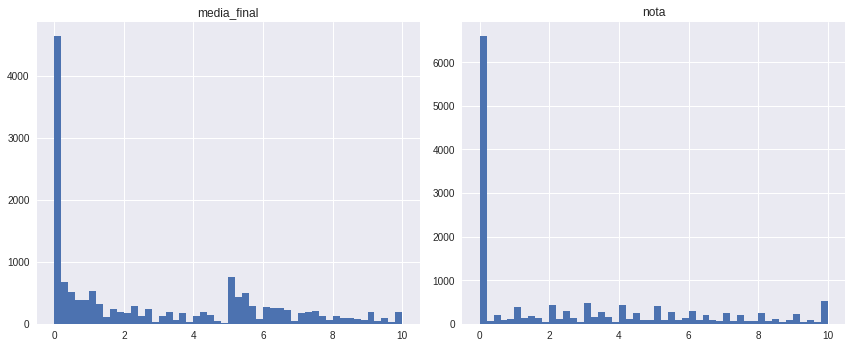

In [194]:
import matplotlib.pyplot as plt

df_final[['media_final','nota']].hist(bins=50, figsize=(12,5))
plt.tight_layout()
plt.show()

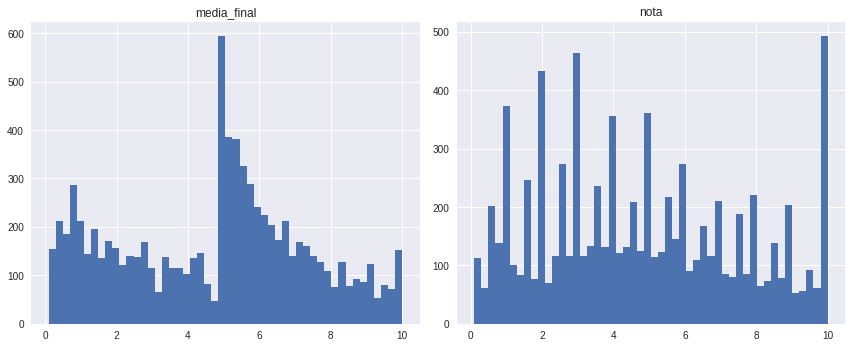

In [196]:
# retirando as notas zero pra ver melhor o comportamento das outras notas
sem_zero = df_final[(df_final['media_final']!=0) & (df_final['nota']!=0)]
sem_zero[['media_final','nota']].hist(bins=50, figsize=(12,5))
plt.tight_layout()
plt.show()

In [214]:
notas_1 = df_final[df_final['unidade']==1.0]
notas_1 = notas_1[['discente','nota']]
notas_1 = notas_1.rename(index=str, columns={"nota": "nota_1"})

notas_2 = df_final[df_final['unidade']==2.0]
notas_2 = notas_2[['discente','nota']]
notas_2 = notas_2.rename(index=str, columns={"nota": "nota_2"})

notas_3 = df_final[df_final['unidade']==3.0]
notas_3 = notas_3[['discente','nota']]
notas_3 = notas_3.rename(index=str, columns={"nota": "nota_3"})

notas_12 = pd.merge(notas_1,notas_2,on='discente')
df_porUnidade = pd.merge(notas_12,notas_3,on='discente')

df_porUnidade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25234 entries, 0 to 25233
Data columns (total 4 columns):
discente    25234 non-null object
nota_1      24694 non-null float64
nota_2      24503 non-null float64
nota_3      24473 non-null float64
dtypes: float64(3), object(1)
memory usage: 985.7+ KB


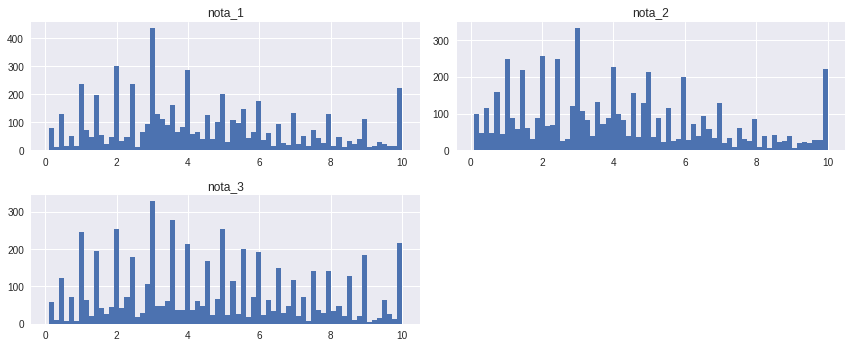

In [217]:
sem_zero2 = df_porUnidade[(df_porUnidade['nota_1']!=0) &
                          (df_porUnidade['nota_2']!=0) &
                          (df_porUnidade['nota_3']!=0)]

sem_zero2.hist(bins=70, figsize=(12,5))
plt.tight_layout()
plt.show()

## 2.6 Conjunto de Teste

In [0]:
# import numpy as np

# # data - dataset
# # test_ratio - percentage used to the test set
# def split_train_test(data, test_ratio):
  
#   #scramble the position
#   shuffled_indices = np.random.permutation(len(data))
#   #find the test set size
#   test_set_size = int(len(data) * test_ratio)
#   #split the indices
#   test_indices = shuffled_indices[:test_set_size]
#   train_indices = shuffled_indices[test_set_size:]
  
#   return data.iloc[train_indices], data.iloc[test_indices]

In [219]:
# train_set, test_set = split_train_test(df_final, 0.2)
# print("data has {} atributes, that is the same of {}\
# train instances + {} test intances ({})".
#       format(len(data),len(train_set),len(test_set),len(train_set)+len(test_set)))

data has 69775 atributes, that is the same of 15340train instances + 3834 test intances (19174)


In [224]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_final, 
                                       test_size=0.2, 
                                       random_state=35)

print("data has {} instances\n {} train instances\n {} test intances".
      format(len(data),len(train_set),len(test_set)))

data has 69775 instances
 15339 train instances
 3835 test intances


# 3.0 Visualizando os dados

In [0]:
treinamento = train_set.copy()

In [0]:
cols_train = ['descricao','discente','id_turma','media_final','nota','reposicao','unidade']
treinamento = treinamento[cols_train]

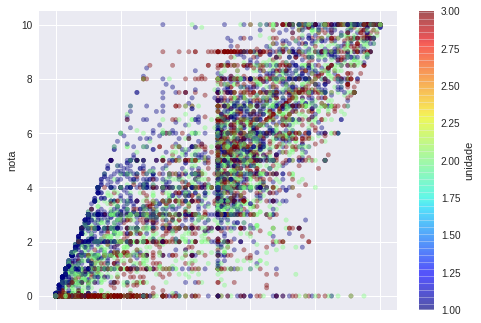

In [247]:
treinamento.plot(kind="scatter", x="media_final", y="nota", alpha=0.4,
           c="unidade", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

- Há uma concentração de notas aproximadamente zero na terceira unidade e essas pessoas obtiveram uma média final baixa.
- Há também um pequeno grupo que se deu bem nas notas da terceira unidade, aproximadamente 9 e sua média final está entre 5 e 6, mostra que se recuperaram ao longe das unidades.

In [248]:
corr_matrix = treinamento.corr()
corr_matrix["nota"].sort_values(ascending=False)

nota           1.000000
media_final    0.907490
id_turma       0.009052
unidade       -0.050193
Name: nota, dtype: float64

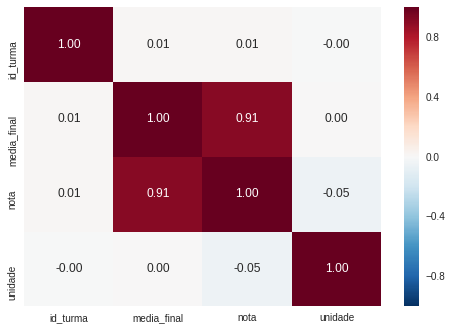

In [249]:
import seaborn as sns

sns.heatmap(treinamento.corr(), annot=True, fmt=".2f")

A correlação apenas confirma o que já é óbvio, que as notas das unidades influenciam na média final do discente.

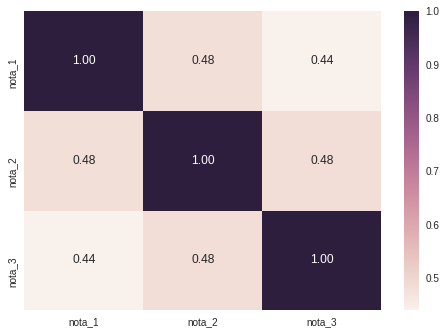

In [250]:
sns.heatmap(df_porUnidade.corr(), annot=True, fmt=".2f")

Acima, é possível observar a correlação entre as notas das unidades.

In [262]:
treinamento.head()

,descricao,discente,id_turma,media_final,nota,reposicao,unidade
58678,TRANCADO,8c156a4955992d16aaf49c7b5c7bd955,1242595,NaN,NaN,f,2.0
384134,APROVADO POR NOTA,db032f1b1cc568bec36a780fc3ed661a,57605537,5.2,3.3,f,1.0
222714,TRANCADO,d65b7b90012df26a2e21778e8320c661,57576610,NaN,NaN,NaN,NaN
58525,APROVADO,59ee909b3d6ccb760e011abbb51a03bc,1242595,8.7,9.5,f,3.0
289406,DESISTENCIA,c360cddfc58c07925ced9a6373d9e02a,57585739,NaN,NaN,NaN,NaN


# 4.0 Tratando os dados

# 5.0 Selecionando e Treinando o Modelo

# 6.0 Melhorar o Modelo

# 7.0 Apresentando a Solução